#### Autor: José Antonio Fernández Aranda
#### Fecha: Diciembre/2024
#### Contenido:
    Caso de Estudio 1.3: Segmentación por Alojamientos Económicos y Bien Ubicados en Granada
    Inteligencia de Negocio
    Universidad de Granada
#### Documentación sobre clustering en Python:
    http://scikit-learn.org/stable/modules/clustering.html
    http://www.learndatasci.com/k-means-clustering-algorithms-python-intro/
    http://hdbscan.readthedocs.io/en/latest/comparing_clustering_algorithms.html
    https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/
    http://www.learndatasci.com/k-means-clustering-algorithms-python-intro/

#### Cargamos las librerias empleadas para la realización del caso de estudio

In [228]:
import time
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth, DBSCAN, Birch, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from sklearn import metrics
from math import floor
import seaborn as sns

#### Definimos la función de normalización de los datos para usarla posteriormente para el procesado de los datos

In [229]:
def norm_to_zero_one(df):
    return (df - df.min()) / (df.max() - df.min())

#### Cargamos los datos de un fichero csv

In [230]:
datos = pd.read_csv('alojamientos_booking_Granada_2024.csv', sep=';', encoding="iso-8859-1")
print(datos.columns.to_list())

['Guests', 'Price avg', 'Ranking position avg', 'Number of views', 'Price difference', 'Hotel name', 'Location', 'Distance', 'Type', 'Quality', 'Rating', 'Special', 'Review', 'Description', 'Bedrooms', 'Living Rooms', 'Bathrooms', 'Kitchens', 'Surface Area (m2)', 'Total Beds', 'Individual Beds', 'Double Beds', 'Double Large Beds', 'Double Extralarge Beds', 'Sofa Beds', 'Bunk Beds']


#### Realizamos un análisis previo de las variables para conocer que columnas le faltan variables

In [231]:
missing_summary = datos.isnull().sum() 
missing_percentage = (missing_summary / len(datos)) * 100

missing_report = pd.DataFrame({
    'Column': datos.columns,
    'Missing Values': missing_summary,
    'Percentage Missing (%)': missing_percentage
}).sort_values(by='Missing Values', ascending=False)

print(missing_report[missing_report['Missing Values'] > 0])

          Column  Missing Values  Percentage Missing (%)
Special  Special            1400                61.70119
Type        Type             215                 9.47554


#### Antes de realizar el filtrado, es necesario imputar los valores de nuestro conjunto de datos. Concretamente necesito imputar los valores de Type

In [232]:
datos['Type'].fillna(datos['Type'].mode()[0], inplace=True)


C:\Users\janto\AppData\Local\Temp\ipykernel_14192\1113160100.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  datos['Type'].fillna(datos['Type'].mode()[0], inplace=True)


#### Para comprobar que se han imputado correctamente la variable Type, realizo la siguiente comprobación

In [233]:
missing_summary = datos.isnull().sum() 
missing_percentage = (missing_summary / len(datos)) * 100

missing_report = pd.DataFrame({
    'Column': datos.columns,
    'Missing Values': missing_summary,
    'Percentage Missing (%)': missing_percentage
}).sort_values(by='Missing Values', ascending=False)

print(missing_report[missing_report['Missing Values'] > 0])

          Column  Missing Values  Percentage Missing (%)
Special  Special            1400                61.70119


#### Seleccionamos las variables y las renombramos para su tratamiento

In [234]:
variables_filtradas = ['Price avg','Ranking position avg','Rating','Distance', 'Review', 'Surface Area (m2)', 'Type', 'Price difference']
variables_usadas = ['Ranking position avg','Rating', 'Surface Area (m2)', 'Type']

#### Antes de aplicar la normalización, es necesario convertir la variable categórica Type a tipo numérico

In [235]:
X = datos[variables_filtradas]

X['Type'] = X['Type'].map({'hotel': 0, 'apartamento': 1})

print(X.head())

   Price avg  Ranking position avg  Rating  Distance  Review  \
0      223.0                 148.0     8.8       450      15   
1      520.0                 248.0    10.0       600       1   
2      615.0                 137.0     7.7       250      85   
3      599.0                 101.0     8.2       250      47   
4      824.0                 285.0     9.6       600      10   

   Surface Area (m2)  Type  Price difference  
0                 85     1              37.0  
1                 70     1              -8.0  
2                 70     1             -40.0  
3                 70     1             -13.0  
4                  0     1             215.0  


C:\Users\janto\AppData\Local\Temp\ipykernel_14192\2631070433.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Type'] = X['Type'].map({'hotel': 0, 'apartamento': 1})


#### Filtramos las variables con los valores que hemos considerado para el estudio

##### Creamos la variable precio medio

In [236]:
average_selected_price = datos[(datos['Distance'] <= 1250) & (datos['Review'] >= 10) ]['Price avg'].mean()

if pd.isna(average_selected_price):
    average_selected_price = datos['Price avg'].mean() 

X['Average selected price'] = average_selected_price

X = X[X['Price avg'] <= X['Average selected price']]

print(f"Filtrados por precio menor o igual al medio: {len(X)} registros")


Filtrados por precio menor o igual al medio: 1467 registros


C:\Users\janto\AppData\Local\Temp\ipykernel_14192\3104153793.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Average selected price'] = average_selected_price


In [237]:
X = X[variables_usadas]
print(X)

      Ranking position avg  Rating  Surface Area (m2)  Type
0                    148.0     8.8                 85     1
6                    117.0     8.6                  0     1
7                    152.0     7.9                  0     1
8                    287.0     9.3                 68     1
9                    157.0     8.1                  0     1
...                    ...     ...                ...   ...
2261                  67.0     6.7                150     1
2262                 259.0     7.9                  0     1
2263                 198.0     9.9                 68     1
2264                 165.0     8.8                  0     1
2265                 306.0     8.1                 45     1

[1467 rows x 4 columns]


#### Por último normalizamos el data set 

In [238]:
X_normal = X.apply(norm_to_zero_one)

### Ejecutamos K - means y medimos sus métricas

In [239]:
print('----- Ejecutando k-Means',end='')
k_means = KMeans(init='k-means++', n_clusters=4, n_init=3, random_state=123456)
t = time.time()
cluster_predict = k_means.fit_predict(X_normal) 
tiempo = time.time() - t
print(": {:.5f} segundos, ".format(tiempo), end='')

----- Ejecutando k-Means: 0.18699 segundos, 

##### Calinski Harabasz métrica: 

In [240]:
metric_CH = metrics.calinski_harabasz_score(X_normal, cluster_predict)
print("Índice Calinski-Harabasz: {:.5f} ".format(metric_CH), end='')

Índice Calinski-Harabasz: 1286.67461 

##### Silhouette métrica: 

In [241]:
muestra_silhouette = 0.2 if (len(X_normal) > 10000) else 1.0
metric_SC = metrics.silhouette_score(X_normal,cluster_predict,metric='euclidean',sample_size=floor(muestra_silhouette * len(X_normal)),random_state=123456)
print("Silhouette Coefficient: {:.5f}".format(metric_SC))

Silhouette Coefficient: 0.42333


##### Davies Bouldin métrica: 

In [242]:
metric_DB = metrics.davies_bouldin_score(X_normal, cluster_predict)
print("Índice Davies Bouldin: {:.5f} ".format(metric_DB), end='')

Índice Davies Bouldin: 0.70036 

#### Tamaño de los clusters

In [243]:
clusters = pd.DataFrame(cluster_predict, index=X.index, columns=['cluster'])

print("Tamaño de cada cluster:")
size = clusters['cluster'].value_counts().sort_index()

for i, c in size.items():
    print('%d: %5d (%5.2f%%)' % (i+1, c, 100 * c / len(clusters)))


Tamaño de cada cluster:
1:   604 (41.17%)
2:   736 (50.17%)
3:    68 ( 4.64%)
4:    59 ( 4.02%)


#### Visualización: Heatmap de centroides

---------- Heatmap de centroides...


(4.0, 0.0)

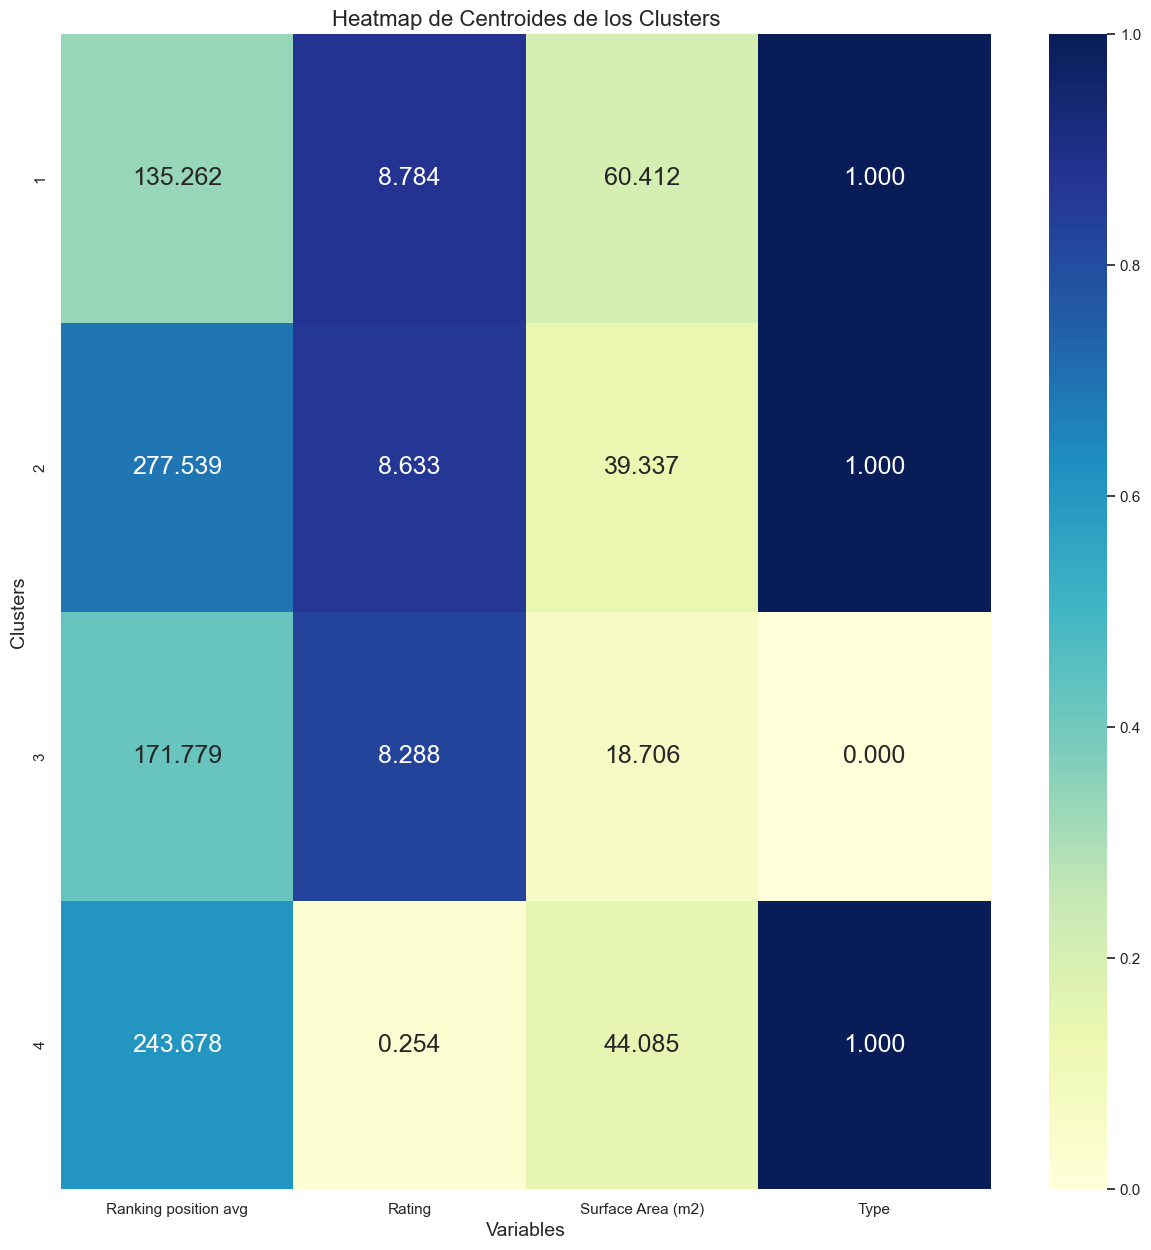

In [244]:
k = len(size)

colors = sns.color_palette(palette='Paired', n_colors=k)

print("---------- Heatmap de centroides...")
centers = pd.DataFrame(k_means.cluster_centers_, columns=list(X))

centers_desnormal = centers.copy()
for var in list(centers):
    centers_desnormal[var] = X[var].min() + centers[var] * (X[var].max() - X[var].min())

centers.index += 1

plt.figure(figsize=(15, 15))
hm = sns.heatmap(
    centers, 
    cmap="YlGnBu", 
    annot=centers_desnormal, 
    annot_kws={"fontsize": 18}, 
    fmt='.3f'
)
hm.set_title("Heatmap de Centroides de los Clusters", fontsize=16)
hm.set_ylabel("Clusters", fontsize=14)
hm.set_xlabel("Variables", fontsize=14)
hm.set_ylim(len(centers), 0)

#### Visualización: Scatter Matrix

---------- Scatter matrix...


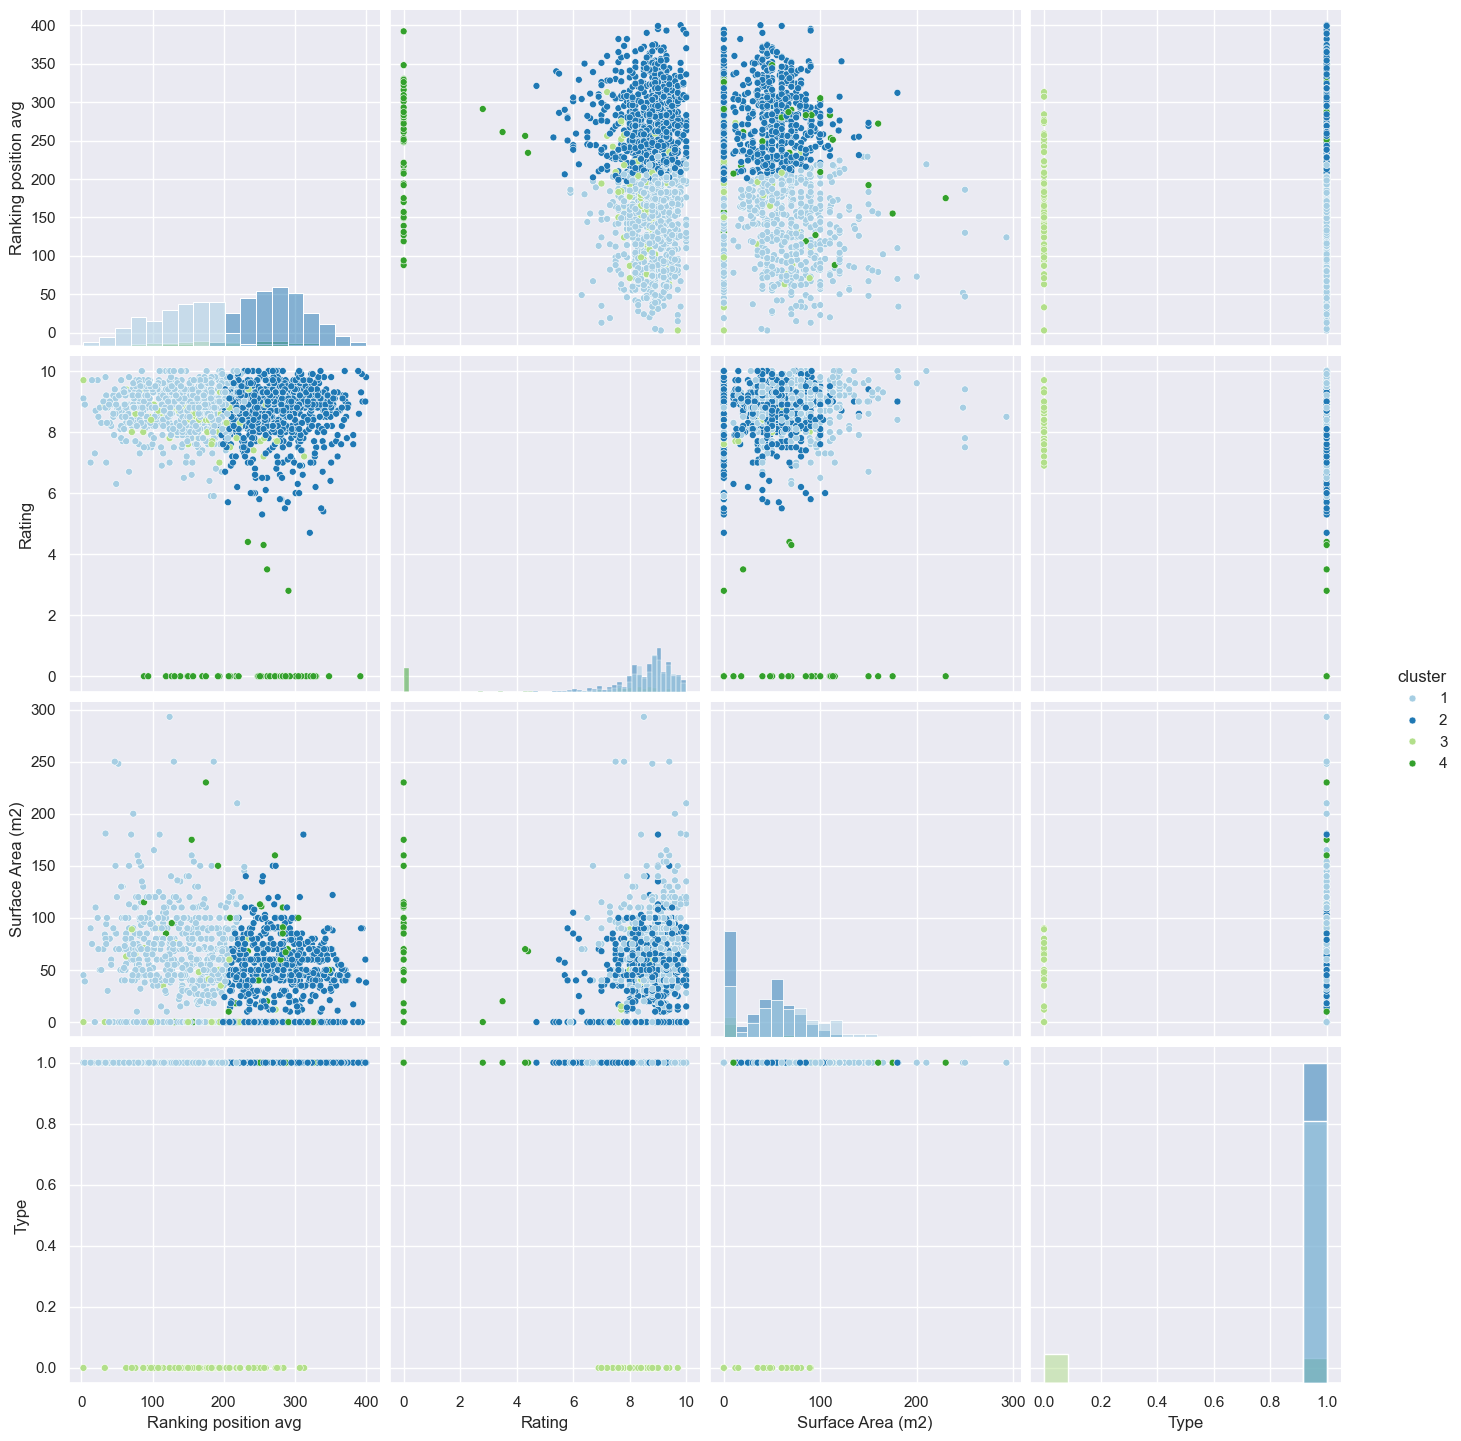

In [246]:
clusters = pd.DataFrame(cluster_predict, index=X.index, columns=['cluster'])

X_kmeans = pd.concat([X, clusters], axis=1)

print("---------- Scatter matrix...")

sns.set()
variables = list(X_kmeans.columns)
variables.remove('cluster')
X_kmeans['cluster'] += 1

sample_size = 5000
X_kmeans_sampled = X_kmeans.sample(n=sample_size, random_state=123456) if len(X_kmeans) > sample_size else X_kmeans

sns_plot = sns.pairplot(
    X_kmeans_sampled,
    vars=variables,
    hue="cluster",
    palette=colors,
    plot_kws={"s": 25},
    diag_kind="hist"
)

sns_plot.fig.subplots_adjust(wspace=0.03, hspace=0.03)
sns_plot.fig.set_size_inches(15, 15)
sns_plot.savefig("scatter.pdf")
plt.show()

X_kmeans['cluster'] -= 1

### Ejecutamos Mean Shift y medimos sus métricas

In [249]:
bw = estimate_bandwidth(X_normal, quantile=0.2, n_samples=50, random_state=123456)
ms = MeanShift(bandwidth=bw, bin_seeding=True)

print("----- Ejecutando MeanShift -----", end='')
t = time.time()
ms.fit(X_normal)
tiempo = time.time() - t
labels = ms.labels_
print(f": {tiempo:.5f} segundos")

clusters = pd.DataFrame(labels, index=X.index, columns=['cluster'])

size = clusters['cluster'].value_counts()

clusters_filtrados = clusters[clusters['cluster'].isin(size[size > 1].index)]

labels_filtrados = clusters_filtrados['cluster'].to_numpy()
X_filtrado = X_normal.loc[clusters_filtrados.index]


----- Ejecutando MeanShift -----: 0.96200 segundos


##### Calinski Harabasz métrica: 

In [250]:
metrics_CH = metrics.calinski_harabasz_score(X_filtrado, labels_filtrados)
print(f"Calinski-Harabasz Index: {metrics_CH:.3f}")

Calinski-Harabasz Index: 769.136


##### Silhouette métrica: 

In [251]:
metric_SC = metrics.silhouette_score(
        X_filtrado, 
        labels_filtrados, 
        metric='euclidean', 
        sample_size=floor(muestra_silhouette * len(X_filtrado)), 
        random_state=123456
)
print("Silhouette Coefficient: {:.5f}".format(metric_SC))

Silhouette Coefficient: 0.63943


##### Davies Bouldin métrica: 

In [69]:
metrics_DB = metrics.davies_bouldin_score(X_filtrado, labels_filtrados)
print(f"Davies-Bouldin Index: {metrics_DB:.3f}")

Davies-Bouldin Index: 0.519


#### Tamaño de los clusters

In [252]:
size = clusters['cluster'].value_counts()

size_filtrados = clusters_filtrados['cluster'].value_counts().sort_index()

print("Tamaño de cada cluster")
for i, (cluster_id, c) in enumerate(size_filtrados.items(), start=1):
    print('%d: %5d (%5.2f%%)' % (i, c, 100 * c / len(clusters_filtrados)))


Tamaño de cada cluster
1:  1341 (91.41%)
2:    68 ( 4.64%)
3:    58 ( 3.95%)


#### Visualización: Heatmap de centroides

Heatmap de centroides generado para clusters con más de un elemento.


<Figure size 640x480 with 0 Axes>

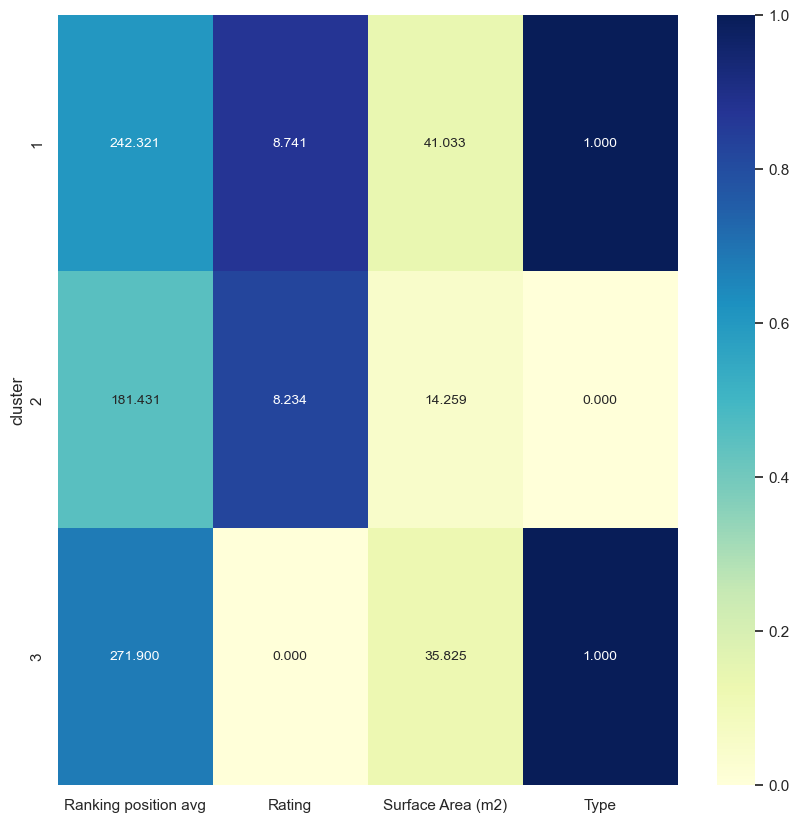

In [253]:
centroides_filtrados = pd.DataFrame(ms.cluster_centers_, columns=X_normal.columns)

centroides_filtrados = centroides_filtrados.loc[size[size > 1].index]

centroides_desnormalizados = centroides_filtrados.copy()

for var in X.columns:
    centroides_desnormalizados[var] = X[var].min() + centroides_filtrados[var] * (X[var].max() - X[var].min())


plt.figure()
centroides_filtrados.index += 1 
plt.figure()
hm = sns.heatmap(centroides_filtrados, cmap="YlGnBu", annot=centroides_desnormalizados, fmt='.3f', annot_kws={"fontsize": 10})
hm.set_ylim(len(centroides_filtrados), 0)
hm.figure.set_size_inches(10, 10)
hm.figure.savefig("centroides_mean_shift_filtrados.pdf")
centroides_filtrados.index -= 1 

print("Heatmap de centroides generado para clusters con más de un elemento.")



#### Visualización: Scatter Matrix

---------- Scatter matrix...


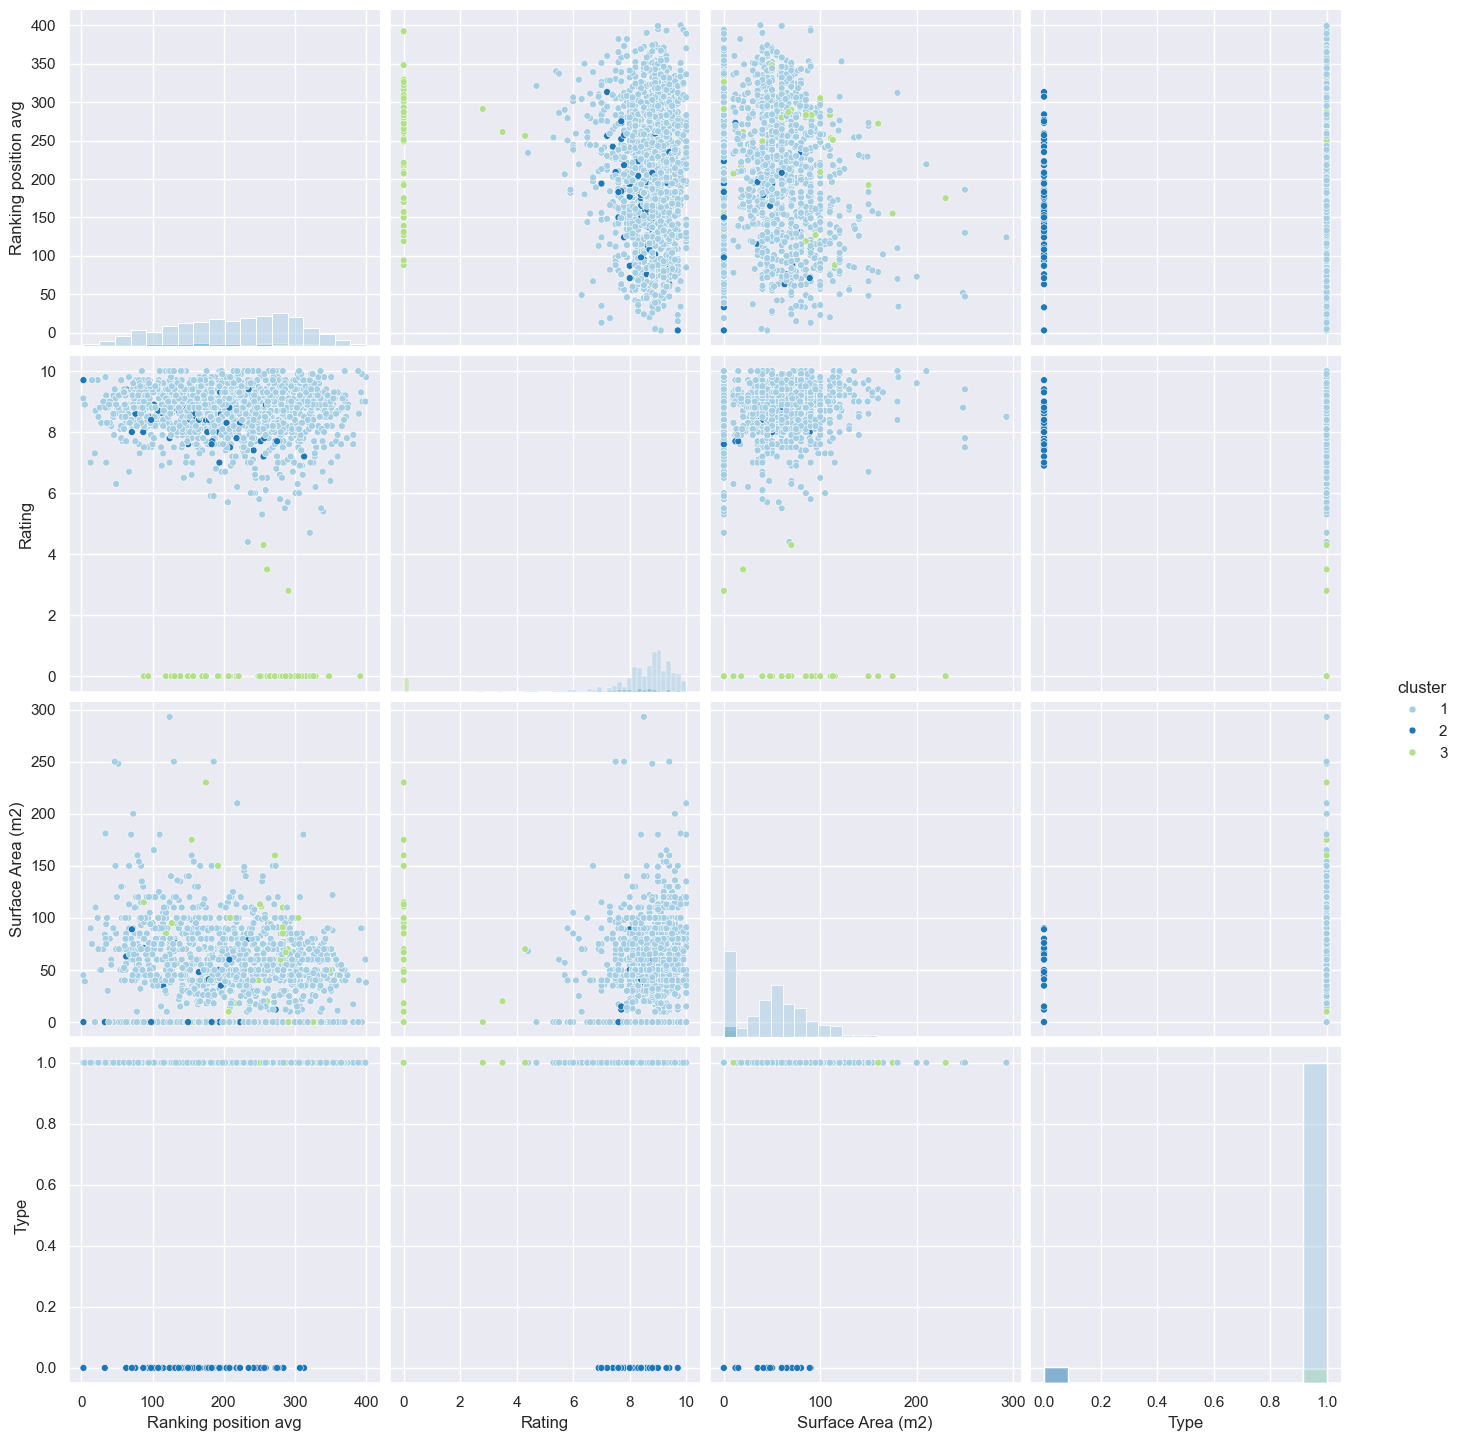

In [254]:
k = len(set(labels_filtrados))
colors = sns.color_palette(palette='Paired', n_colors=k)[:len(set(labels_filtrados))]

clusters_filtrados_df = pd.DataFrame(labels_filtrados, index=X_filtrado.index, columns=['cluster'])
X_meanshift_filtrado = pd.concat([X.loc[X_filtrado.index], clusters_filtrados_df], axis=1)

print("---------- Scatter matrix...")

sns.set()
variables = list(X_meanshift_filtrado.columns)
variables.remove('cluster')
X_meanshift_filtrado['cluster'] += 1 

sample_size = 5000
X_meanshift_sampled = X_meanshift_filtrado.sample(n=sample_size, random_state=123456) if len(X_meanshift_filtrado) > sample_size else X_meanshift_filtrado

sns_plot = sns.pairplot(
    X_meanshift_sampled,
    vars=variables,
    hue="cluster",
    palette=colors,
    plot_kws={"s": 25},  
    diag_kind="hist"  
)

sns_plot.fig.subplots_adjust(wspace=0.03, hspace=0.03)
sns_plot.fig.set_size_inches(15, 15)
sns_plot.savefig("scatter_meanshift.pdf") 
plt.show()

X_meanshift_filtrado['cluster'] -= 1




### Ejecutamos DBSCAN y medimos sus métricas 

In [293]:
sample_fraction = 1
X_dbscan = X_normal.sample(frac=sample_fraction, random_state=42)

eps = 0.6
min_samples = 20

print("------ Ejecutando DBSCAN ------")
dbscan = DBSCAN(eps=eps, min_samples=min_samples, algorithm="ball_tree", n_jobs=-1)

start_time = time.time()
clusters_dbscan = dbscan.fit_predict(X_dbscan)
end_time = time.time()
print(f"DBSCAN completado en {end_time - start_time:.5f} segundos")

clusters = pd.DataFrame(clusters_dbscan, index=X_dbscan.index, columns=['cluster'])

labels_filtrados = clusters['cluster'].to_numpy()
X_filtrado = X_dbscan.loc[clusters.index]


------ Ejecutando DBSCAN ------
DBSCAN completado en 0.06455 segundos


##### Calinski Harabasz métrica: 

In [294]:
metrics_CH = metrics.calinski_harabasz_score(X_filtrado, labels_filtrados)
print(f"Calinski-Harabasz Index: {metrics_CH:.5f}")

Calinski-Harabasz Index: 681.80647


##### Silhouette métrica: 

In [295]:
muestra_silhouette = 0.2 if len(X_filtrado) > 10000 else 1.0
metric_SC = metrics.silhouette_score(
        X_filtrado, 
        labels_filtrados, 
        metric='euclidean', 
        sample_size=floor(muestra_silhouette * len(X_filtrado)),
        random_state=123456
)
print(f"Silhouette Coefficient: {metric_SC:.5f}")

Silhouette Coefficient: 0.65286


##### Davies Bouldin métrica: 

In [296]:
metrics_DB = metrics.davies_bouldin_score(X_filtrado, labels_filtrados)
print(f"Davies-Bouldin Index: {metrics_DB:.5f}")

Davies-Bouldin Index: 0.44271


#### Tamaño de los clusters

In [297]:
size = clusters['cluster'].value_counts()

clusters_filtrados = clusters[clusters['cluster'].isin(size[size > 1].index)]

size_filtrados = clusters_filtrados['cluster'].value_counts().sort_index()

print("Tamaño de cada cluster:")
for i, (cluster_id, c) in enumerate(size_filtrados.items(), start=1):
    print('%d: %5d (%5.2f%%)' % (i, c, 100 * c / len(clusters_filtrados)))

Tamaño de cada cluster:
1:  1399 (95.36%)
2:    68 ( 4.64%)


#### Visualización: Heatmap de centroides

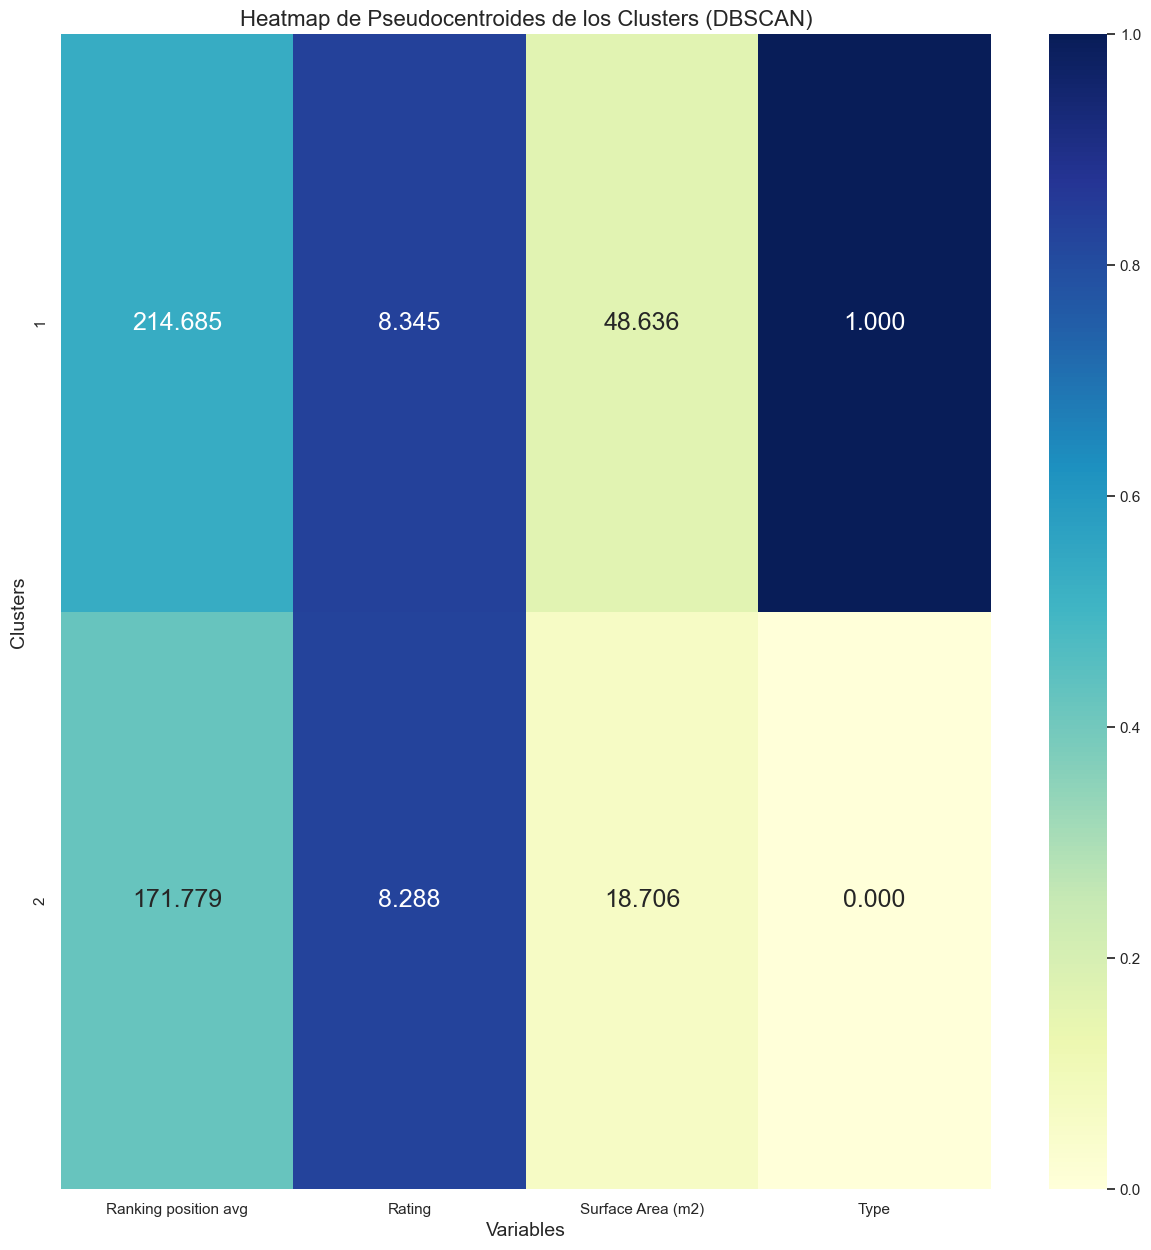

In [298]:
clusters = pd.DataFrame(labels_filtrados, index=X_filtrado.index, columns=['cluster'])

centers = clusters.join(X_filtrado).groupby('cluster').mean()

centers_desnormal = centers.copy()
for var in centers.columns:
    centers_desnormal[var] = X[var].min() + centers[var] * (X[var].max() - X[var].min())

centers.index += 1 

plt.figure(figsize=(15, 15))
hm = sns.heatmap(
    centers, 
    cmap="YlGnBu", 
    annot=centers_desnormal,
    annot_kws={"fontsize": 18},
    fmt='.3f'
)
hm.set_title("Heatmap de Pseudocentroides de los Clusters (DBSCAN)", fontsize=16)
hm.set_ylabel("Clusters", fontsize=14)
hm.set_xlabel("Variables", fontsize=14)
hm.set_ylim(len(centers), 0)

plt.show()


#### Visualización: Scatter Matrix

---------- Scatter matrix...


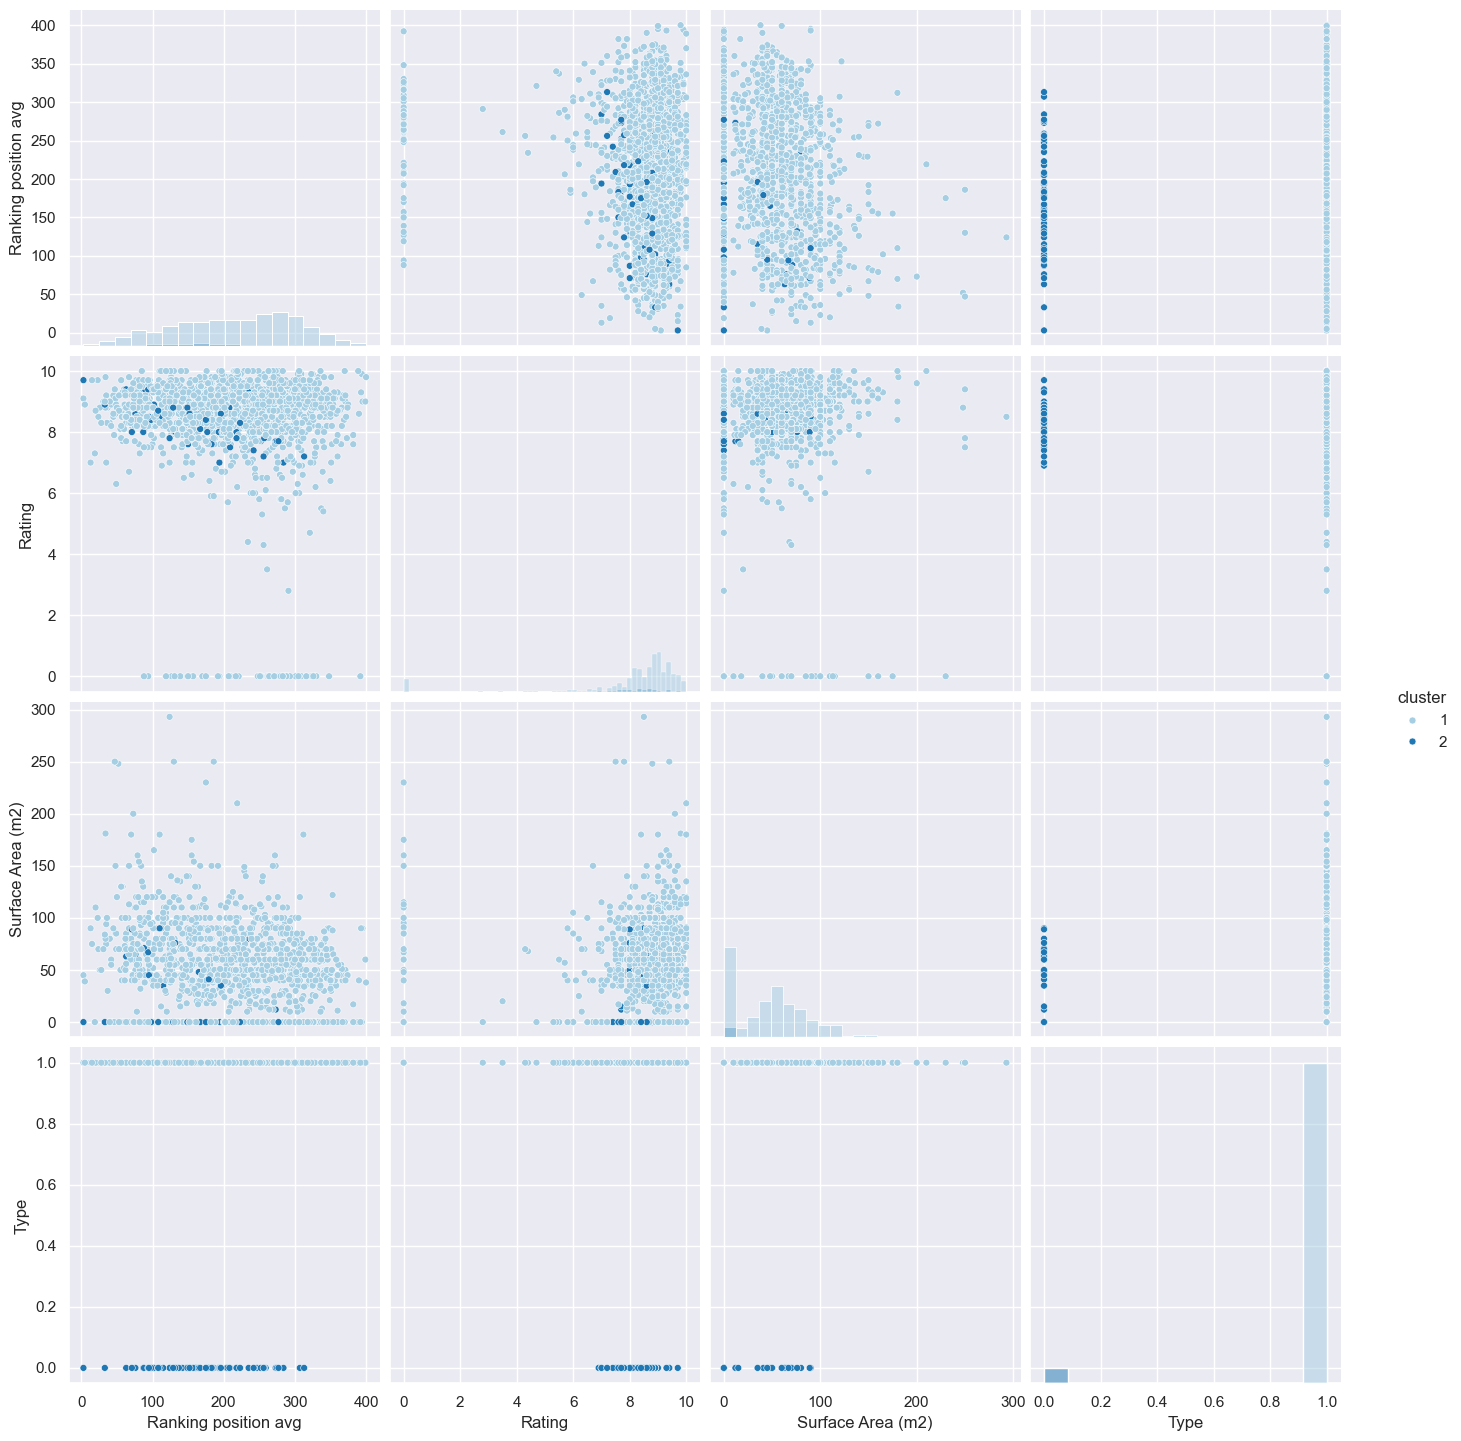

In [299]:
labels_unicos = sorted(set(labels_filtrados) - {-1})
k = len(labels_unicos)
colors = sns.color_palette('Paired', n_colors=k)

clusters_filtrados_df = pd.DataFrame(labels_filtrados, index=X_filtrado.index, columns=['cluster'])
clusters_filtrados_df = clusters_filtrados_df[clusters_filtrados_df['cluster'].isin(labels_unicos)]

X_dbscan_filtrado = pd.concat([X.loc[clusters_filtrados_df.index], clusters_filtrados_df], axis=1)

print("---------- Scatter matrix...")

sns.set()
variables = list(X_dbscan_filtrado.columns)
variables.remove('cluster')
X_dbscan_filtrado['cluster'] += 1  

sample_size = 5000
X_dbscan_sampled = X_dbscan_filtrado.sample(n=sample_size, random_state=123456) if len(X_dbscan_filtrado) > sample_size else X_dbscan_filtrado

sns_plot = sns.pairplot(
    X_dbscan_sampled,
    vars=variables,
    hue="cluster",
    palette=colors,
    plot_kws={"s": 25},
    diag_kind="hist"
)

sns_plot.fig.subplots_adjust(wspace=0.03, hspace=0.03)
sns_plot.fig.set_size_inches(15, 15)
sns_plot.savefig("scatter_dbscan.pdf")
plt.show()

X_dbscan_filtrado['cluster'] -= 1


### Ejecutamos BIRCH y medimos sus métricas 

In [328]:
n_clusters = 2
threshold = 0.3
branching_factor = 10

birch = Birch(n_clusters=n_clusters, threshold=threshold, branching_factor=branching_factor)

print("----- Ejecutando BIRCH -----")
start_time = time.time()
labels = birch.fit_predict(X_normal)
end_time = time.time()
print(f"BIRCH completado en {end_time - start_time:.5f} segundos")

clusters = pd.DataFrame(labels, index=X.index, columns=['cluster'])

size = clusters['cluster'].value_counts()

labels_filtrados = clusters['cluster'].to_numpy()
X_filtrado = X_normal.loc[clusters.index]

----- Ejecutando BIRCH -----
BIRCH completado en 0.05800 segundos


##### Calinski Harabasz métrica: 

In [329]:
metric_CH = metrics.calinski_harabasz_score(X_filtrado, labels_filtrados)
print(f"Calinski-Harabasz Index: {metrics_CH:.3f}")

Calinski-Harabasz Index: 681.806


##### Silhouette métrica: 

In [330]:
muestra_silhouette = 0.2 if len(X_filtrado) > 10000 else 1.0

metric_SC = metrics.silhouette_score(
    X_filtrado,
    labels_filtrados,
    metric='euclidean',
    sample_size=floor(muestra_silhouette * len(X_filtrado)),
    random_state=42
)
print(f"Silhouette Coefficient: {metric_SC:.5f}")

Silhouette Coefficient: 0.65286


##### Davies Bouldin métrica: 

In [331]:
metric_DB = metrics.davies_bouldin_score(X_filtrado, labels_filtrados)
print(f"Davies-Bouldin Index: {metric_DB:.5f}")


Davies-Bouldin Index: 0.44271


#### Tamaño de los clusters

In [332]:
size = clusters['cluster'].value_counts().sort_index()

print("Tamaño de cada cluster:")
for i, (cluster_id, count) in enumerate(size.items(), start=1):
    print(f"{i}: {count:5d} ({100 * count / len(clusters):5.2f}%)")



Tamaño de cada cluster:
1:  1399 (95.36%)
2:    68 ( 4.64%)


#### Visualización: Heatmap de centroides

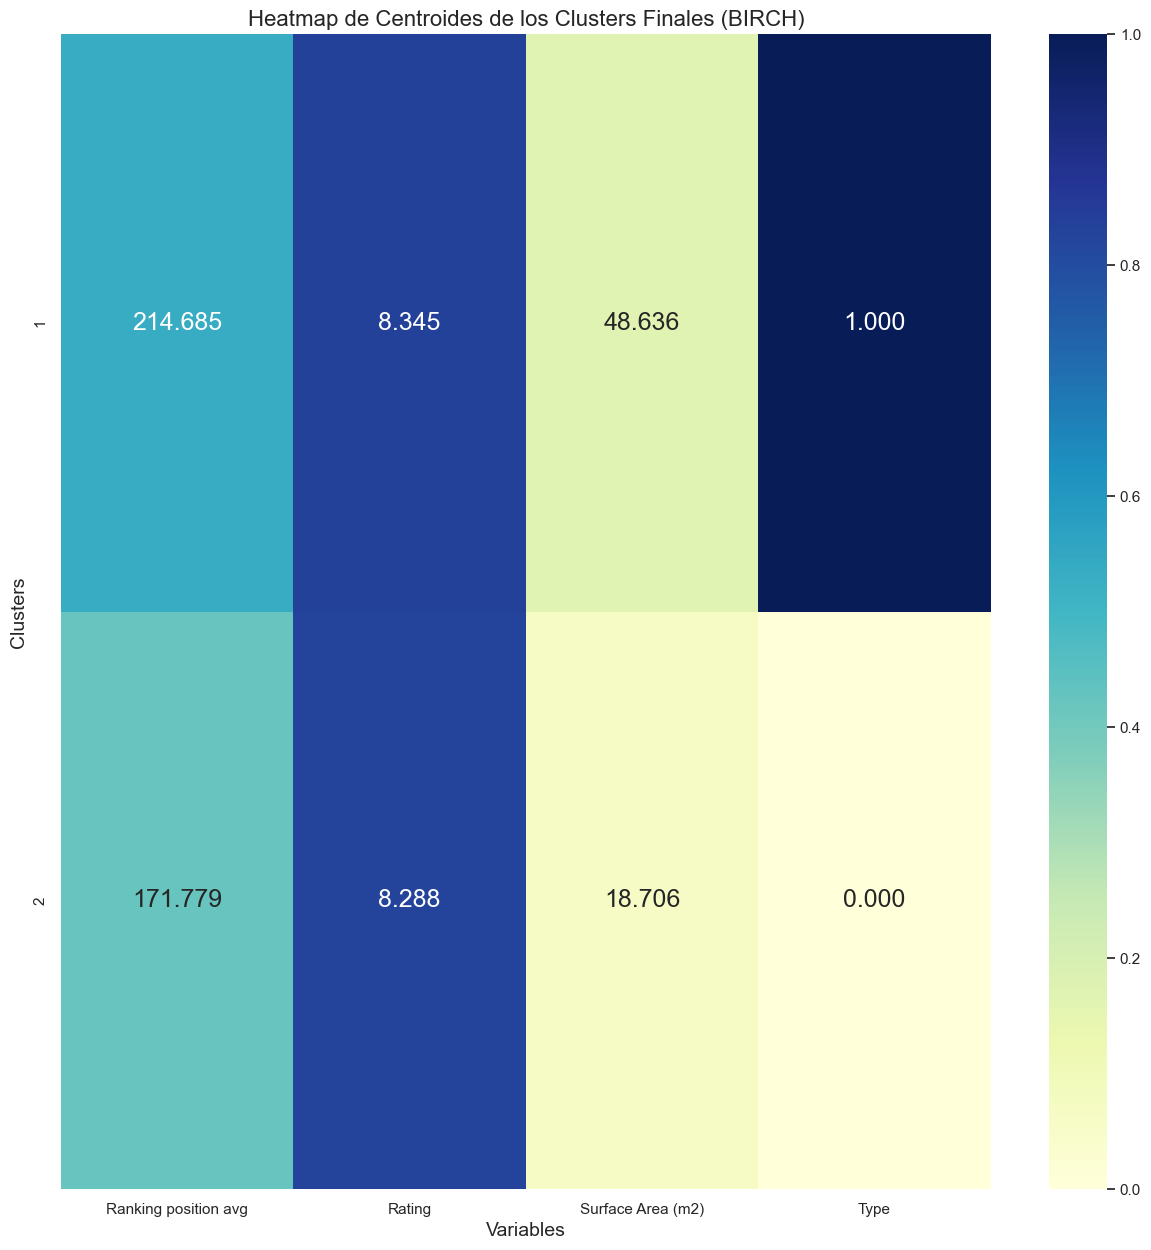

In [333]:
clusters_finales = pd.DataFrame(labels_filtrados, index=X_filtrado.index, columns=['cluster'])

centers_finales = X_filtrado.groupby(clusters_finales['cluster']).mean()

centers_desnormal = centers_finales.copy()
for var in list(centers_finales.columns):
    centers_desnormal[var] = X[var].min() + centers_finales[var] * (X[var].max() - X[var].min())

centers_finales.index += 1

plt.figure(figsize=(15, 15))
hm = sns.heatmap(
    centers_finales, 
    cmap="YlGnBu", 
    annot=centers_desnormal,
    annot_kws={"fontsize": 18},
    fmt='.3f'
)
hm.set_title("Heatmap de Centroides de los Clusters Finales (BIRCH)", fontsize=16)
hm.set_ylabel("Clusters", fontsize=14)
hm.set_xlabel("Variables", fontsize=14)
hm.set_ylim(len(centers_finales), 0)

plt.show()


#### Visualización: Scatter Matrix

---------- Scatter matrix...


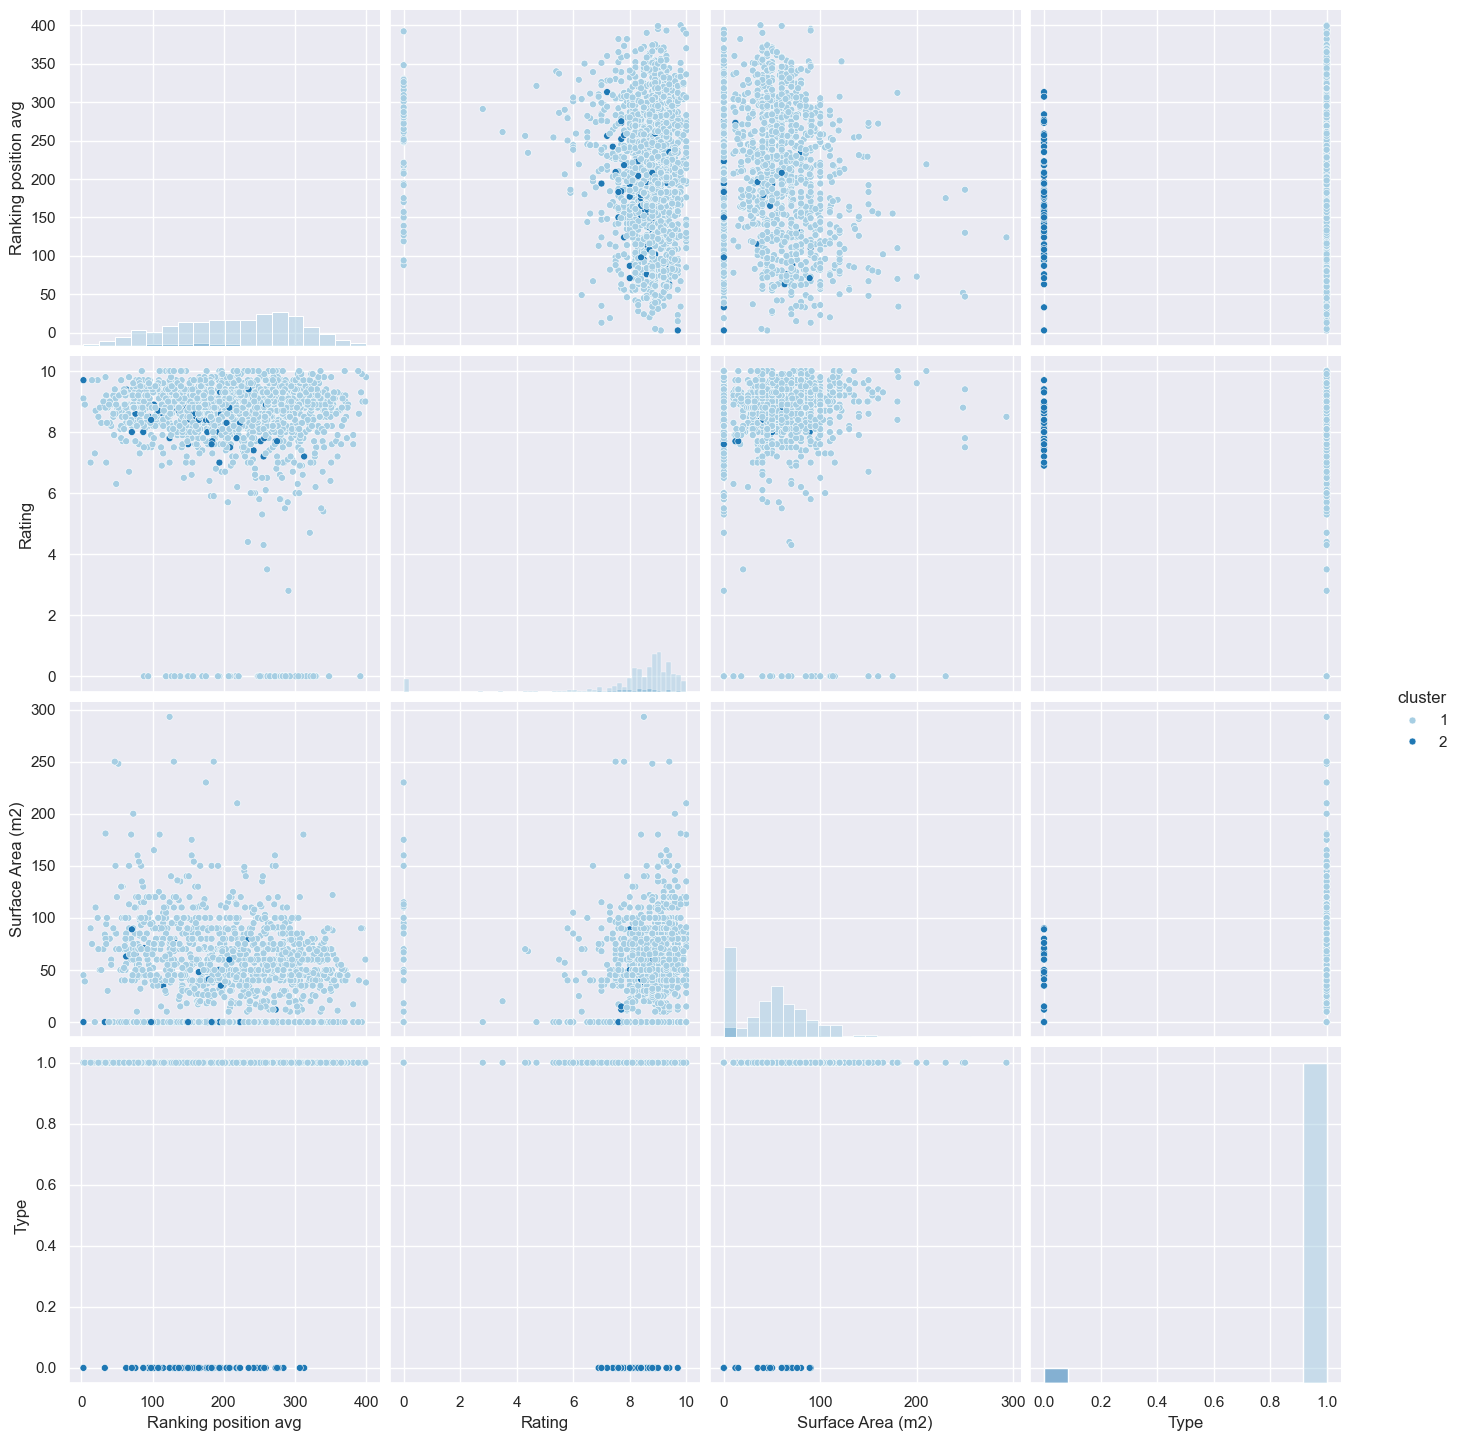

In [334]:
k = len(set(labels_filtrados))
colors = sns.color_palette(palette='Paired', n_colors=k)

clusters_filtrados_df = pd.DataFrame(labels_filtrados, index=X_filtrado.index, columns=['cluster'])

X_birch_filtrado = pd.concat([X.loc[X_filtrado.index], clusters_filtrados_df], axis=1)

print("---------- Scatter matrix...")

sns.set()
variables = list(X_birch_filtrado.columns)
variables.remove('cluster')
X_birch_filtrado['cluster'] += 1 

sample_size = 5000
X_birch_sampled = X_birch_filtrado.sample(n=sample_size, random_state=123456) if len(X_birch_filtrado) > sample_size else X_birch_filtrado

sns_plot = sns.pairplot(
    X_birch_sampled,
    vars=variables,
    hue="cluster",
    palette=colors,  
    plot_kws={"s": 25},  
    diag_kind="hist"  
)

sns_plot.fig.subplots_adjust(wspace=0.03, hspace=0.03) 
sns_plot.fig.set_size_inches(15, 15)  
sns_plot.savefig("scatter_birch.pdf")  
plt.show()

X_birch_filtrado['cluster'] -= 1  


### Ejecutamos Método Jerárquico Aglomerativo de Enlace Simple

In [339]:
n_clusters = 2
linkage = "single"

agg_clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage, metric="euclidean")

print("----- Ejecutando Método Jerárquico (Enlace Simple) -----")
start_time = time.time()
labels = agg_clustering.fit_predict(X_normal)
end_time = time.time()
print(f"Método jerárquico completado en {end_time - start_time:.5f} segundos")

clusters = pd.DataFrame(labels, index=X_normal.index, columns=['cluster'])

labels_filtrados = clusters['cluster'].to_numpy()
X_filtrado = X_normal.loc[clusters.index]


----- Ejecutando Método Jerárquico (Enlace Simple) -----
Método jerárquico completado en 0.04300 segundos


##### Calinski Harabasz métrica: 

In [343]:
metric_CH = metrics.calinski_harabasz_score(X_filtrado, labels_filtrados)
print(f"Calinski-Harabasz Index: {metric_CH:.5f}")


Calinski-Harabasz Index: 681.80647


##### Silhouette métrica: 

In [344]:
muestra_silhouette = 0.2 if len(X_filtrado) > 10000 else 1.0

metric_SC = metrics.silhouette_score(
    X_filtrado,
    labels_filtrados,
    metric='euclidean',
    sample_size=floor(muestra_silhouette * len(X_filtrado)),
    random_state=42
)
print(f"Silhouette Coefficient: {metric_SC:.5f}")

Silhouette Coefficient: 0.65286


##### Davies Bouldin métrica: 

In [345]:
metric_DB = metrics.davies_bouldin_score(X_filtrado, labels_filtrados)
print(f"Davies-Bouldin Index: {metric_DB:.5f}")

Davies-Bouldin Index: 0.44271


#### Tamaño de los clusters

In [347]:
size = clusters['cluster'].value_counts()

size_filtrados = clusters['cluster'].value_counts().sort_index()

print("Tamaño de cada clusters:")
for i, (cluster_id, c) in enumerate(size_filtrados.items(), start=1):
    print('%d: %5d (%5.2f%%)' % (i, c, 100 * c / len(clusters_filtrados)))


Tamaño de cada clusters:
1:  1399 (95.36%)
2:    68 ( 4.64%)


#### Visualización: Heatmap de centroides

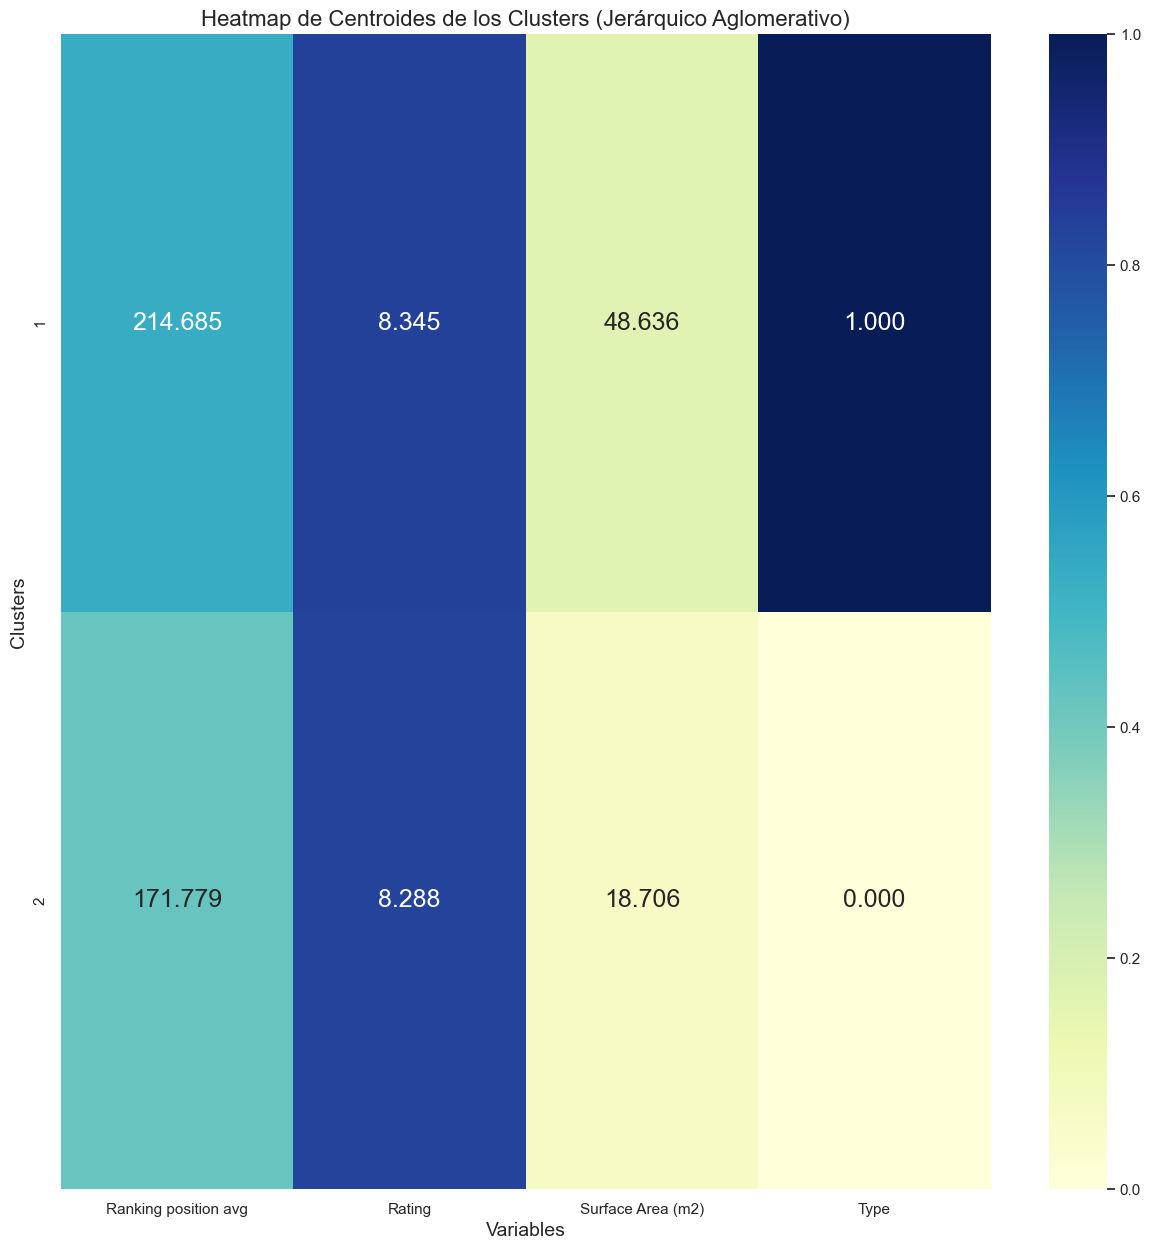

In [348]:
centers = pd.DataFrame([
    X_filtrado[labels_filtrados == cluster_id].mean()
    for cluster_id in np.unique(labels_filtrados)
], columns=list(X_normal))

centers_desnormal = centers.copy()
for var in list(centers):
    centers_desnormal[var] = X[var].min() + centers[var] * (X[var].max() - X[var].min())

centers.index += 1  

plt.figure(figsize=(15, 15))
hm = sns.heatmap(
    centers, 
    cmap="YlGnBu", 
    annot=centers_desnormal,
    annot_kws={"fontsize": 18},
    fmt='.3f'
)
hm.set_title("Heatmap de Centroides de los Clusters (Jerárquico Aglomerativo)", fontsize=16)
hm.set_ylabel("Clusters", fontsize=14)
hm.set_xlabel("Variables", fontsize=14)
hm.set_ylim(len(centers), 0)

plt.show()


#### Visualización: Dendograma

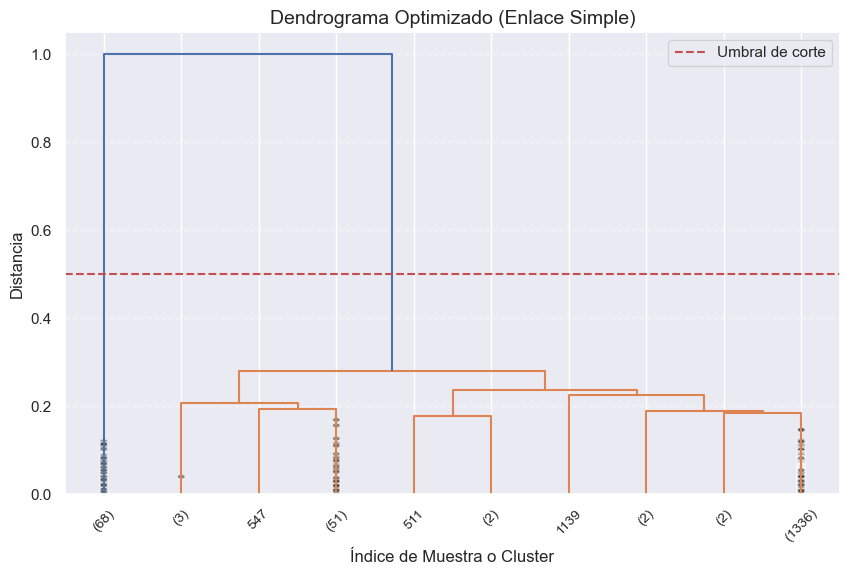

In [349]:
from scipy.cluster.hierarchy import linkage, dendrogram

n_muestra = min(10000, len(X_normal))

X_sample = X_normal.sample(n=n_muestra, random_state=123)

Z = linkage(X_sample, method='single')

plt.figure(figsize=(10, 6))
dendrogram(
    Z,
    truncate_mode="lastp", 
    p=10,                  
    leaf_rotation=45,      
    leaf_font_size=10,     
    show_contracted=True   
)

plt.axhline(y=0.5, color='r', linestyle='--', label="Umbral de corte")
plt.title("Dendrograma Optimizado (Enlace Simple)", fontsize=14)
plt.xlabel("Índice de Muestra o Cluster", fontsize=12)
plt.ylabel("Distancia", fontsize=12)
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()



#### Visualización: Scatter Matrix

---------- Scatter matrix...


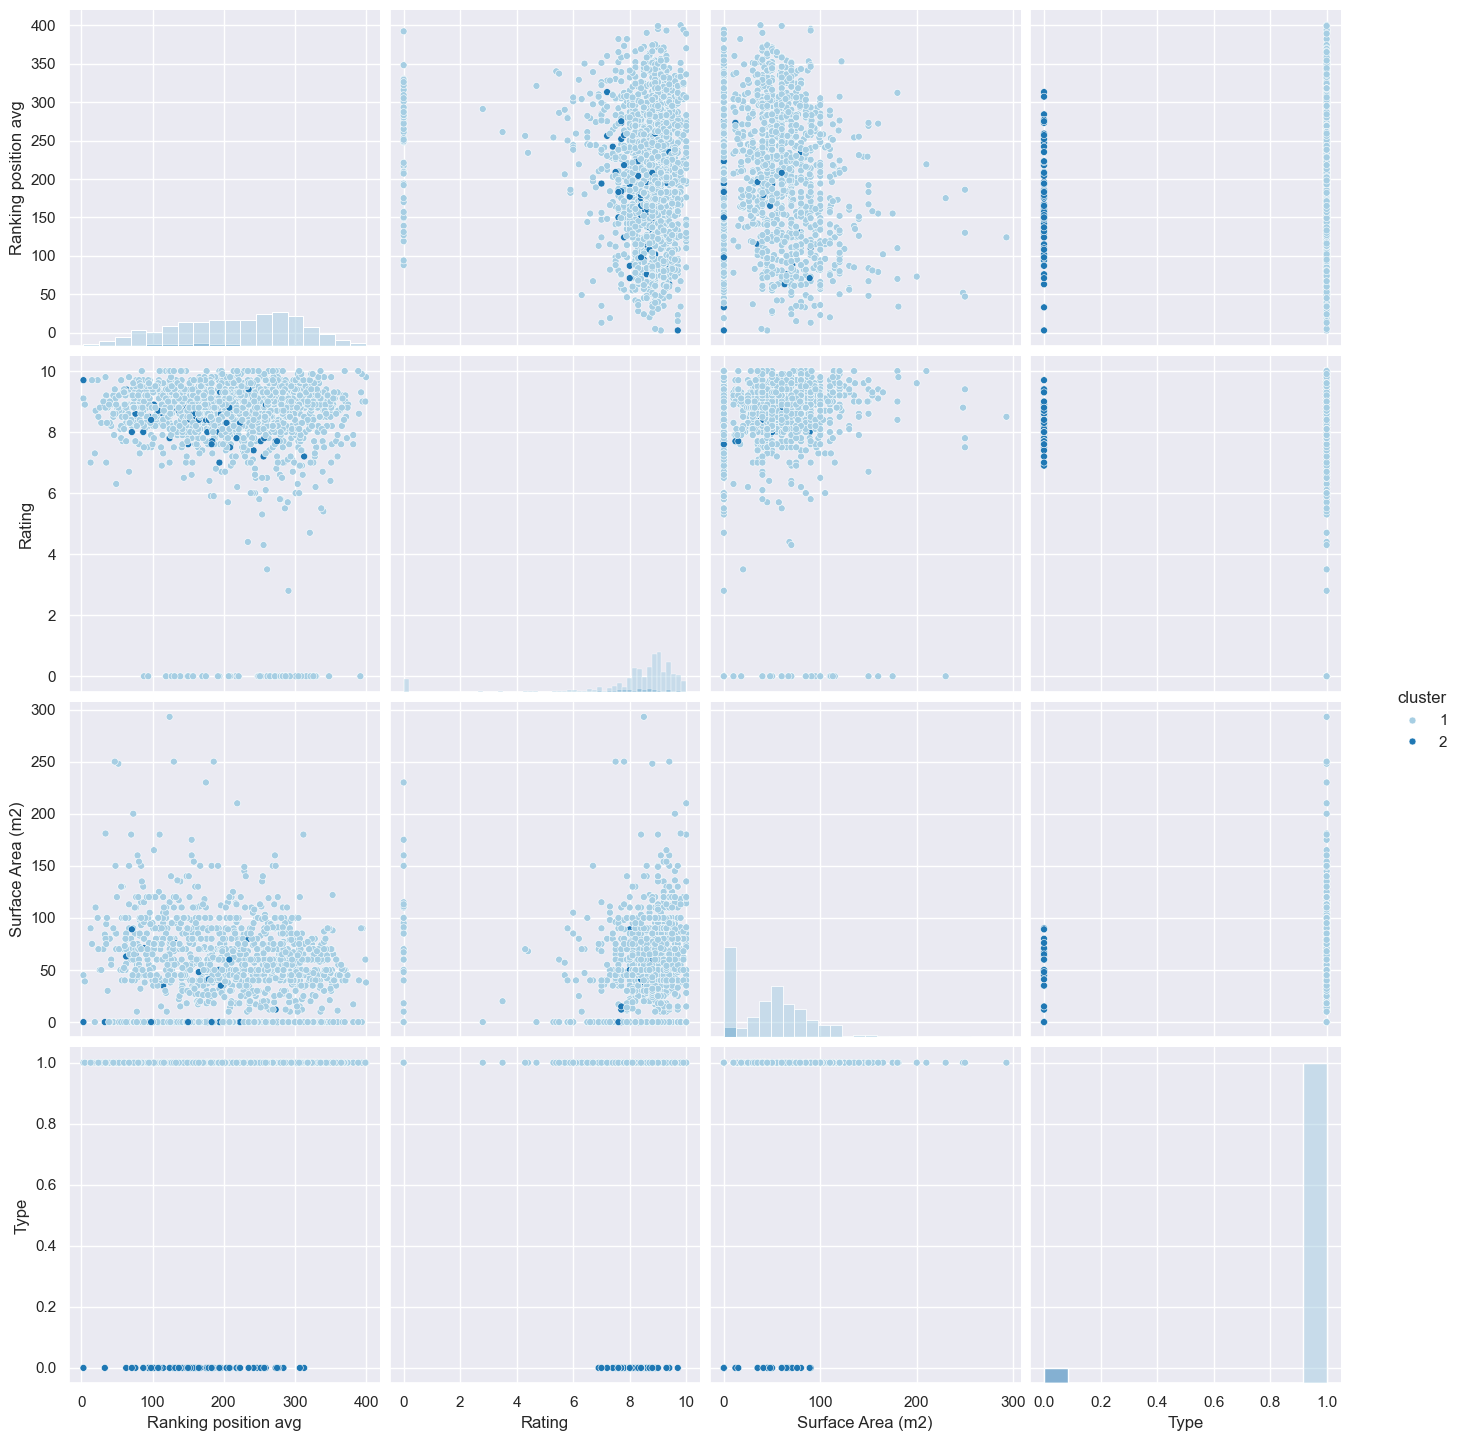

In [350]:
k = len(set(labels_filtrados))
colors = sns.color_palette(palette='Paired', n_colors=k)

clusters_filtrados_df = pd.DataFrame(labels_filtrados, index=X_filtrado.index, columns=['cluster'])

X_hierarchical_filtrado = pd.concat([X.loc[X_filtrado.index], clusters_filtrados_df], axis=1)

print("---------- Scatter matrix...")

sns.set()
variables = list(X_hierarchical_filtrado.columns)
variables.remove('cluster')
X_hierarchical_filtrado['cluster'] += 1 

sample_size = 5000
X_hierarchical_sampled = X_hierarchical_filtrado.sample(n=sample_size, random_state=123456) if len(X_hierarchical_filtrado) > sample_size else X_hierarchical_filtrado

sns_plot = sns.pairplot(
    X_hierarchical_sampled,
    vars=variables,
    hue="cluster",
    palette=colors,  
    plot_kws={"s": 25},  
    diag_kind="hist"  
)

sns_plot.fig.subplots_adjust(wspace=0.03, hspace=0.03) 
sns_plot.fig.set_size_inches(15, 15)  
sns_plot.savefig("scatter_hierarchical.pdf")  
plt.show()

X_hierarchical_filtrado['cluster'] -= 1  
